### Loading sound files and preparing data

In [3]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib.patches import ConnectionPatch

In [4]:
def load_sound_files(dir='data/'):
    representative_sounds = {}
    digit_sounds = {}

    for filename in os.listdir(dir):
        if filename.endswith('.wav'):
            codes = filename.split('.')[0].split('-')
            digit = codes[0]
            file_path = os.path.join(dir, filename)
            # load sound file
            audio_data, _ = librosa.load(file_path)
            # representative digit sound
            if codes[1] == '42' and codes[2] == '20':
                representative_sounds[digit] = audio_data
            # rest of the sounds
            else:
                if digit not in digit_sounds:
                    digit_sounds[digit] = []
                digit_sounds[digit].append(audio_data)

    return representative_sounds, digit_sounds

Representative sounds 

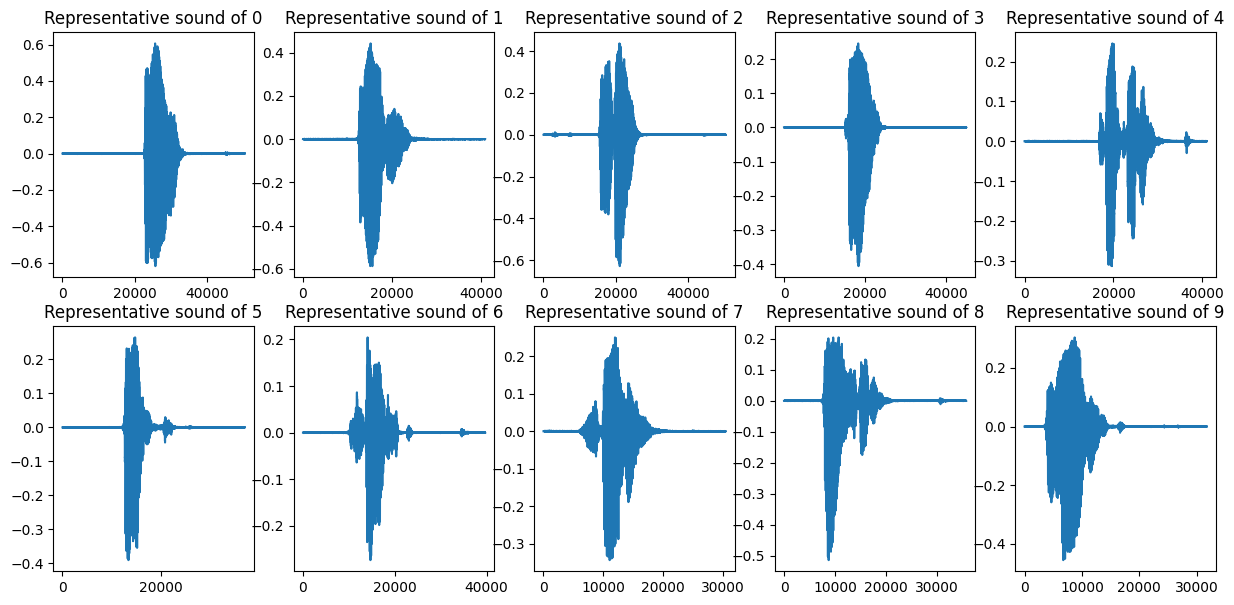

In [5]:
rep_sounds, digit_sounds = load_sound_files()

# plot the representative sounds
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
for i, ax in enumerate(axs.flat):
    ax.plot(rep_sounds[str(i)])
    ax.set_title(f'Representative sound of {i}')
plt.show()


### Making prediction

##### DTW (Dynamic Time Warping)

Function that uses DTW algorithm

In [79]:
def dtw(x, y, dist_fun):
    n = len(x)
    m = len(y)

    dist_matrix = np.zeros((n, m))

    # calculate distance matrix
    for i in range(n):
        for j in range(m):
            dist_matrix[i, j] = dist_fun(x[i], y[j])

    # initialize cost matrix and traceback matrix with zeros
    cost_matrix = np.zeros((n, m))
    cost_matrix[0, 0] = dist_matrix[0, 0]
    traceback_matrix = np.zeros((n, m))

    for i in range(1, n):
        cost_matrix[i, 0] = dist_matrix[i, 0] + cost_matrix[i-1, 0]

    for j in range(1, m):
        cost_matrix[0, j] = dist_matrix[0, j] + cost_matrix[0, j-1]

    # finding the optimal cost and path using dp
    for i in range(1, n):
        for j in range(1, m):
            penalty = [
                cost_matrix[i-1, j-1], # match
                cost_matrix[i-1, j],   # insertion
                cost_matrix[i, j-1]    # deletion
            ]
            min_penalty_idx = np.argmin(penalty)
            cost_matrix[i, j] = dist_matrix[i, j] + penalty[min_penalty_idx]
            traceback_matrix[i, j] = min_penalty_idx

    # traceback
    i = n-1
    j = m-1
    path = [(i, j)]

    while (i > 0 or j > 0) and np.abs(i)-1 < n and np.abs(j)-1 < m:
        if traceback_matrix[i, j] == 0: # match
            i -= 1
            j -= 1
        elif traceback_matrix[i, j] == 1: # insertion
            i -= 1
        else: # deletion
            j -= 1
        path.append((i, j))
    
    # return dtw normalized cost and path
    return cost_matrix[n-1, m-1] / (n + m), path[::-1]

Function for plotting results of warping

In [7]:
def plotting_cost_matrix(cost_matrix, path):
    plt.figure(figsize=(15, 7))
    plt.title('Cost matrix')
    plt.imshow(cost_matrix, cmap='gray_r', interpolation="nearest",origin='lower')
    x_path, y_path = zip(*path)
    plt.plot(x_path, y_path, color='purple')
    plt.show()

In [8]:
# ref = rep_sounds['0']
# test = digit_sounds['0'][0]

ref = [1, 2, 3, 4, 5]
test = [1, 2, 3, 4, 5]

cost, path = dtw(ref, test, lambda x, y: np.abs(x - y))
print(f'DTW normalized cost: {cost}')

DTW normalized cost: 0.0


Mel-scale spectogram

In [9]:
def plot_mel_spectrogram(audio_data):
    mel_spec = librosa.feature.melspectrogram(y=audio_data, n_fft=2048, hop_length=512, n_mels=40)
    log_mel_spec = np.log(mel_spec + 1e-9)
    # Plot the Mel spectrogram
    _, ax = plt.subplots(figsize=(15, 7))
    ax.imshow(log_mel_spec, origin='lower', interpolation='nearest')
    plt.title('Mel Spectrogram')
    plt.xlabel('Frames') 
    plt.ylabel('Mel Feature dimension')
    plt.show()

In [10]:
def plot_mfcc(audio_data):
    mfccs = librosa.feature.mfcc(y=audio_data, n_fft=2048, hop_length=512, n_mfcc=25)
    # Plot the MFCCs
    _, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(mfccs, origin='lower', interpolation='nearest')
    plt.title('MFCC')
    plt.xlabel('Frames')
    plt.ylabel('MFCC Coefficients')
    plt.show()

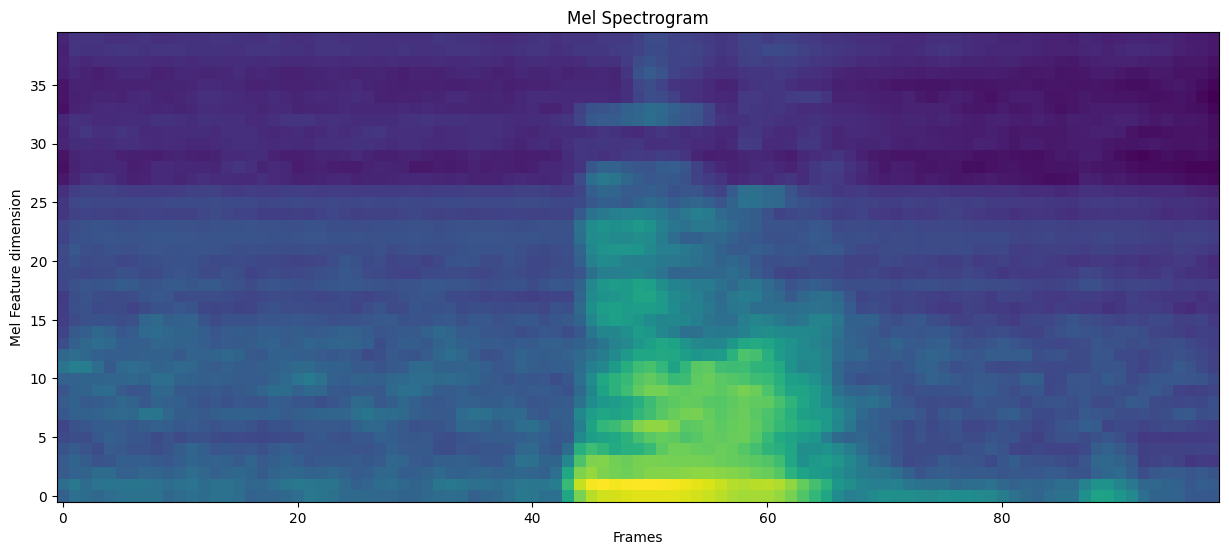

In [11]:
plot_mel_spectrogram(rep_sounds['0'])

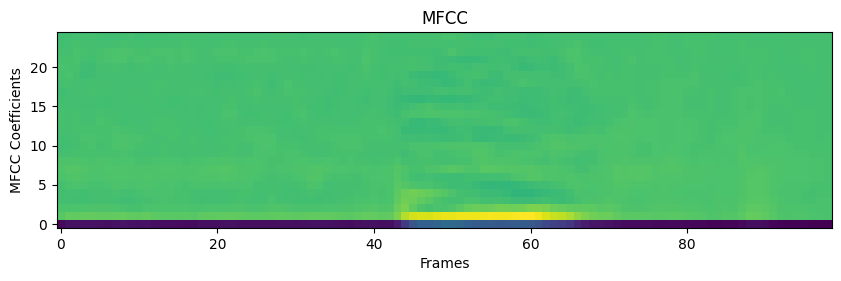

In [12]:
plot_mfcc(rep_sounds['0'])


In [13]:
def plot_lpc(audio_data):
    # Apply LPC analysis
    order = 12  # LPC order (number of coefficients)
    lpc_coeffs = librosa.lpc(audio_data, order=order)
    
    # Plot the LPC coefficients
    plt.figure(figsize=(8, 5))
    plt.plot(lpc_coeffs, color='purple')
    plt.title('LPC Coefficients')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

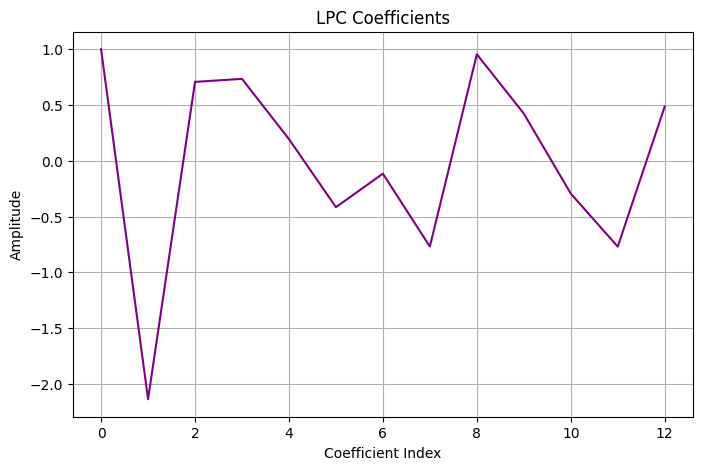

In [14]:
plot_lpc(rep_sounds['0'])

In [22]:
def plot_dtw(sample_data, ref_data, path, title, other_plot=False):
    if not other_plot:
        fig = plt.figure(figsize=(10, 10))
        fig.suptitle(title)
        ax1 = fig.add_subplot(311)
        ax2 = fig.add_subplot(313)

        ax1.imshow(ref_data, origin='lower', interpolation='nearest')
        ax2.imshow(sample_data, origin='lower', interpolation='nearest')
        ax1.set_title('Representative sound')
        ax2.set_title('Sample sound')
        ax1.axis('off')
        ax2.axis('off')

        for x_i, y_j in path:
            con = ConnectionPatch(
                xyA=(x_i, 0), xyB=(y_j, sample_data.shape[0]-1),
                coordsA="data", coordsB="data", axesA=ax1, axesB=ax2,
                color="purple"
            )
            ax2.add_artist(con)
    else:
        plt.figure(figsize=(6, 4))
        # plot allignment
        for x_i, y_j in path:
            plt.plot([x_i, y_j], [ref_data[x_i] + 1.5, sample_data[y_j] - 1.5], color='purple')
        plt.plot(np.arange(len(ref_data)), ref_data + 1.5, "-o", color='blue', label='Representative sound')
        plt.plot(np.arange(len(sample_data)), sample_data - 1.5, "-o", color='red', label='Sample sound')

In [81]:

# comparator compare given sound, returns the class, optional -> prints sorted dtw for each of the classes
# class needs transformation method and plotting method
class SoundComparator():
    def __init__(self, ref_sounds, threshold):
        self.ref_sounds = ref_sounds
        self.thresholds = threshold
        self.ref_preprocessed = self.preprocess_ref_sounds(ref_sounds)

    def preprocess_ref_sounds(self, ref_sounds):
        preprocessed_refs = {}
        for digit, ref_sound in self.ref_sounds.items():
            log_mel_spec, mfccs, lpc_coeffs = self.all_preprocessing(ref_sound)
            preprocessed_refs[digit] = (log_mel_spec, mfccs, lpc_coeffs)  

        return preprocessed_refs

    def all_preprocessing(self, sound, n_mels=42, n_mfcc=25, order=12):
        # Mel spectrogram
        log_mel_spec = self.mel_preprocessing(sound, n_mels)

        # MFCC
        mfccs = librosa.feature.mfcc(y=sound, n_fft=2048, hop_length=512, n_mfcc=n_mfcc)
        mfccs = mfccs.T

        # LPC order (number of coefficients)
        lpc_coeffs = librosa.lpc(sound, order=order)
        # lpc_coeffs = lpc_coeffs.T

        return log_mel_spec, mfccs, lpc_coeffs
    
    def mel_preprocessing(self, sound, n_mels=42):
        # Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=sound, n_fft=2048, hop_length=512, n_mels=n_mels)
        log_mel_spec = np.log(mel_spec + 1e-9)
        log_mel_spec = log_mel_spec.T

        return log_mel_spec


    def compare_diff_preprocess(self, test_sound, plot=False):
        dtw_costs = {}
        dtw_paths = {}                
        log_mel_spec, mfccs, lpc_coeffs = self.all_preprocessing(test_sound)
        
        # calculate dtw betweem each of the representative sounds and sample sound
        for digit, ref_sound in self.ref_preprocessed.items():
            dtw_costs[digit] = []
            dtw_paths[digit] = []
            cost1, path1 = dtw(log_mel_spec, ref_sound[0], lambda x, y: cosine(x, y))
            cost2, path2 = dtw(mfccs, ref_sound[1], lambda x, y: cosine(x, y))
            cost3, path3 = dtw(lpc_coeffs, ref_sound[2], lambda x, y: (x - y)**2)
            dtw_costs[digit] += [cost1, cost2, cost3]
            dtw_paths[digit] += [path1, path2, path3]

        # find the minimum cost1 and cost2 and cost3 and which digit it belongs to
        min_cost1, min_cost2, min_cost3 = 100000, 100000, 100000
        min_digit1, min_digit2, min_digit3 = None, None, None
        min_path1, min_path2, min_path3 = None, None, None

        for digit, costs in dtw_costs.items():
            if costs[0] < min_cost1:
                min_cost1 = costs[0]
                min_digit1 = digit
                min_path1 = dtw_paths[digit][0]
            if costs[1] < min_cost2:
                min_cost2 = costs[1]
                min_digit2 = digit
                min_path2 = dtw_paths[digit][1]
            if costs[2] < min_cost3:
                min_cost3 = costs[2]
                min_digit3 = digit
                min_path3 = dtw_paths[digit][2]

        # show dtw distances for each of the preprocessing methods
        print(f'Log Mel spectrogram min DTW distances: {min_cost1}, for digit {min_digit1}')
        print(f'MFCC min DTW distances: {min_cost2}, for digit {min_digit2}')
        print(f'LPC min DTW distances: {min_cost3}, for digit {min_digit3}')
        
        # plotting dynamic time warping between test sound and representative sound
        if plot:   
            plot_dtw(log_mel_spec, self.ref_preprocessed[min_digit1][0], min_path1, 'Log Mel spectrogram')
            plot_dtw(mfccs, self.ref_preprocessed[min_digit2][1], min_path2, 'MFCC')
            plot_dtw(lpc_coeffs, self.ref_preprocessed[min_digit3][2], min_path3, 'LPC', True)     



    def predict(self, test_sound, real_digit, plot=False):
        log_mel_spec = self.mel_preprocessing(test_sound)
        min_cost = 100000
        min_digit = None
        min_path = None

        for digit, ref_sound in self.ref_preprocessed.items():
            cost, path = dtw(log_mel_spec, ref_sound[0], lambda x, y: cosine(x, y))
            if cost < min_cost:
                min_cost = cost
                min_digit = digit
                min_path = path

        if min_cost > self.thresholds:
            print('Unknown sound')
        else:
            print(f'Predicted digit: {min_digit} and real digit is: {real_digit}')

            if plot:
                plot_dtw(log_mel_spec, self.ref_preprocessed[min_digit][0], min_path, 'Log Mel spectrogram')

In [ ]:
comparator = SoundComparator(rep_sounds, threshold=0.05)
# comparator.compare_diff_preprocess(digit_sounds['0'][4], plot=True)
comparator.predict(digit_sounds['0'][2], 0, plot=True)